In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

# EDA

In [2]:
df = pd.read_csv('energy.dat')

In [3]:
df

,Date,Consumption
0,01-Apr-15,357.073
1,02-Apr-15,341.931
2,03-Apr-15,318.777
3,04-Apr-15,312.494
4,05-Apr-15,270.837
...,...,...
1822,27-Mar-20,237.171
1823,28-Mar-20,229.744
1824,29-Mar-20,297.636
1825,30-Mar-20,323.811


In [4]:
df.dtypes

Date            object
Consumption    float64
dtype: object

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.dtypes

Date           datetime64[ns]
Consumption           float64
dtype: object

In [7]:
df = df.rename(columns={'Date':'ds','Consumption':'ts'})

In [8]:
df.shape

(1827, 2)

Text(0, 0.5, 'consumption')

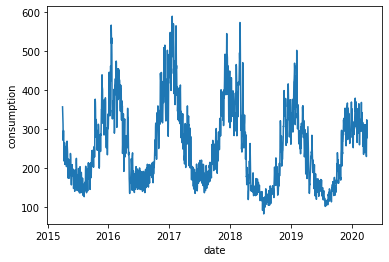

In [9]:
plt.figure()
plt.plot(df.ds, df.ts)
plt.xlabel('date')
plt.ylabel('consumption')

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
def log_trans(df,ts): return df[ts].apply(lambda x:np.log(x))

In [12]:
df['ts_log']=log_trans(df,'ts')

In [13]:
df

,ds,ts,ts_log
0,2015-04-01,357.073,5.877940
1,2015-04-02,341.931,5.834609
2,2015-04-03,318.777,5.764492
3,2015-04-04,312.494,5.744585
4,2015-04-05,270.837,5.601517
...,...,...,...
1822,2020-03-27,237.171,5.468781
1823,2020-03-28,229.744,5.436966
1824,2020-03-29,297.636,5.695871
1825,2020-03-30,323.811,5.780160


# Training, validation, test split

In [14]:
# constructing training, validation and test sets
def data_train_validate_test(df, training_set_percent=0.7, validation_set_percent=0.15, seed=None):
  length = len(df.index)  #size of index of dataset
  training_set_end = int(training_set_percent * length)  #size of the training set
  validation_set_end = int(validation_set_percent * length) + training_set_end  #size of the validation set + training set
  training = df.loc[:training_set_end] #select random rows up to the size of the training set to form the training dataset
  validation = df.loc[training_set_end+1:validation_set_end] #select random rows up to the size of validation set to form the validation dataset
  test = df.loc[validation_set_end+1:] #The remaining rows from the validation set onwards to the end will be the test dataset
  return training, validation, test

In [15]:
# generate training, validation and test sets
df_training, df_validation, df_test = data_train_validate_test(df)

In [16]:
# check the shapes of the training, validation and test sets
df_training.shape, df_validation.shape, df_test.shape

((1279, 3), (274, 3), (274, 3))

In [17]:
# relabel the index terms to ds terms
df_training.index = df_training.ds 
df_validation.index = df_validation.ds
df_test.index = df_test.ds
df_training

,ds,ts,ts_log
ds,,,
2015-04-01,2015-04-01,357.073,5.877940
2015-04-02,2015-04-02,341.931,5.834609
2015-04-03,2015-04-03,318.777,5.764492
2015-04-04,2015-04-04,312.494,5.744585
2015-04-05,2015-04-05,270.837,5.601517
...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146
2018-09-27,2018-09-27,155.628,5.047469
2018-09-28,2018-09-28,182.789,5.208332


# Dickey-Fuller tests and testing for stationarity

In [18]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2, figsize=(15,5), sharex=True)

  ax1.plot(df[ts],label="Original")
  ax1.legend(loc ='best')
  ax1.tick_params(axis ='x', rotation=45)

  ax2.plot(df[trend],label="Trend")
  ax2.legend(loc ='best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(df[seasonal],label="Seasonal")
  ax3.legend(loc ='best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(df[residual],label="Residuals")
  ax4.legend(loc = 'best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout()

  plt.show()


In [19]:
# given that the interval between data points was by day, the decomposition period was taken as 365

In [20]:
decomposition = seasonal_decompose(df_training['ts_log'], period=364, extrapolate_trend=1)

In [21]:
New_DF_training=df_training.copy()
New_DF_training.loc[:,'trend']=decomposition.trend
New_DF_training.loc[:,'seasonal']=decomposition.seasonal
New_DF_training.loc[:,'residuals']=decomposition.resid

In [22]:
New_DF_training

,ds,ts,ts_log,trend,seasonal,residuals
ds,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.564159,0.233209,0.080573
2015-04-02,2015-04-02,341.931,5.834609,5.563982,0.155362,0.115264
2015-04-03,2015-04-03,318.777,5.764492,5.563806,0.096171,0.104515
2015-04-04,2015-04-04,312.494,5.744585,5.563629,0.019969,0.160988
2015-04-05,2015-04-05,270.837,5.601517,5.563453,-0.066007,0.104071
...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.284537,-0.151493,0.019102
2018-09-27,2018-09-27,155.628,5.047469,5.283784,-0.168453,-0.067862
2018-09-28,2018-09-28,182.789,5.208332,5.283030,-0.126924,0.052227


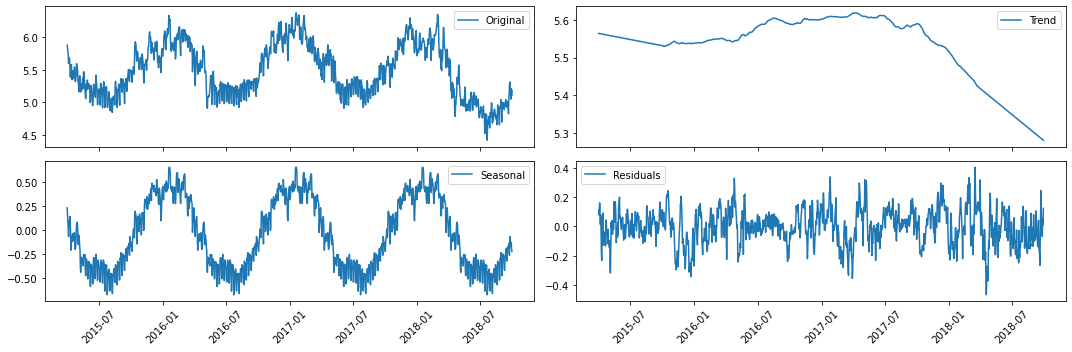

In [23]:
plot_decomposition(New_DF_training,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def test_stationary(df, ts):
  #determine Rolling Statistics
  rolmean = df[ts].rolling(window=12, center = False).mean()
  rolstd = df[ts].rolling(window=12, center = False).std()

  orig = plt.plot(df[ts],color='blue',label='Original')
  mean = plt.plot(rolmean,color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling StD')

  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation =45)
  plt.show(block =False)
  plt.close

  #Dickey-Fuller test: Null Hypothesis (H_0): time series is not stationary
  #Alternate Hypothesis(H_1): time series is stationary 
  #p-value is the probability of an observed (or more extreme) result assuming that the null hypothesis is true 
  #if p-value is less than 0.05 then reject null hypothesis   


  print('Results:')
  dftest = adfuller(df[ts],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index =['Test Statistic','p-value','# Lags Used','Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key]= value

  print(dfoutput)

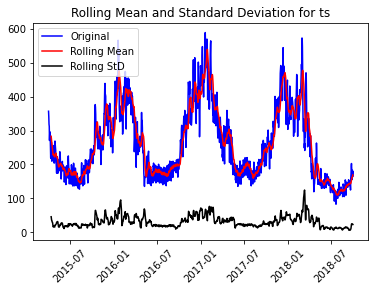

Results:
Test Statistic              -1.997251
p-value                      0.287780
# Lags Used                 23.000000
Number of Observations    1255.000000
Critical value(1%)          -3.435571
Critical value(5%)          -2.863846
Critical value(10%)         -2.567998
dtype: float64


In [26]:
# test for stationarity on the full signal
test_stationary(New_DF_training,'ts')

- therefore when carrying out Dickey-Fuller test on full signal, we see that the p-value is greater than 0.05 hence we accept the null hypothesis that the time series is not stationary i.e. the mean and standard deviation are changing

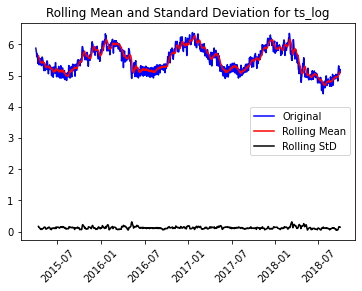

Results:
Test Statistic              -1.928100
p-value                      0.318960
# Lags Used                 23.000000
Number of Observations    1255.000000
Critical value(1%)          -3.435571
Critical value(5%)          -2.863846
Critical value(10%)         -2.567998
dtype: float64


In [27]:
# test for stationarity on the log of the full signal
test_stationary(New_DF_training,'ts_log')

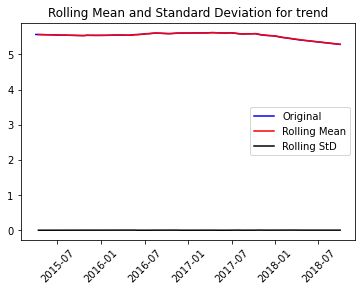

Results:
Test Statistic               1.679485
p-value                      0.998077
# Lags Used                 15.000000
Number of Observations    1263.000000
Critical value(1%)          -3.435538
Critical value(5%)          -2.863831
Critical value(10%)         -2.567990
dtype: float64


In [28]:
test_stationary(New_DF_training,'trend')

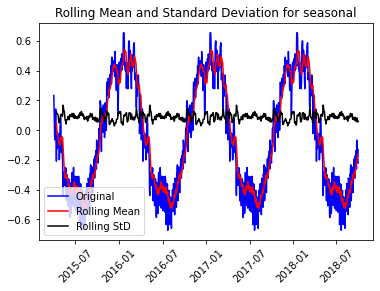

Results:
Test Statistic              -2.341605
p-value                      0.158900
# Lags Used                 21.000000
Number of Observations    1257.000000
Critical value(1%)          -3.435563
Critical value(5%)          -2.863842
Critical value(10%)         -2.567996
dtype: float64


In [29]:
test_stationary(New_DF_training,'seasonal')

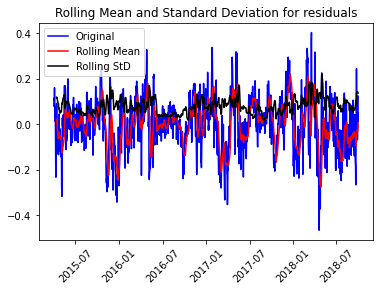

Results:
Test Statistic           -6.610748e+00
p-value                   6.386319e-09
# Lags Used               1.400000e+01
Number of Observations    1.264000e+03
Critical value(1%)       -3.435534e+00
Critical value(5%)       -2.863829e+00
Critical value(10%)      -2.567989e+00
dtype: float64


In [30]:
# test for stationarity on the residuals
test_stationary(New_DF_training, 'residuals')

- therefore when carrying out Dickey-Fuller test on the residuals, we see that the p-value is less than 0.05 hence we reject the null hypothesis that the time series is not stationary and accept the alternate hypothesis i.e. the mean and standard deviation are not changing

# curve fit to trend

In [31]:
New_DF_training_OLS = New_DF_training.copy()

In [32]:
New_DF_training_OLS.reset_index(drop=True, inplace=True)

In [33]:
New_DF_training_OLS['index'] = New_DF_training_OLS.index

In [34]:
New_DF_training_OLS['index'] += 1

In [35]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index
0,2015-04-01,357.073,5.877940,5.564159,0.233209,0.080573,1
1,2015-04-02,341.931,5.834609,5.563982,0.155362,0.115264,2
2,2015-04-03,318.777,5.764492,5.563806,0.096171,0.104515,3
3,2015-04-04,312.494,5.744585,5.563629,0.019969,0.160988,4
4,2015-04-05,270.837,5.601517,5.563453,-0.066007,0.104071,5
...,...,...,...,...,...,...,...
1274,2018-09-26,172.802,5.152146,5.284537,-0.151493,0.019102,1275
1275,2018-09-27,155.628,5.047469,5.283784,-0.168453,-0.067862,1276
1276,2018-09-28,182.789,5.208332,5.283030,-0.126924,0.052227,1277
1277,2018-09-29,163.487,5.096733,5.282277,-0.197560,0.012017,1278


In [36]:
X = New_DF_training_OLS['index'].to_numpy()

In [37]:
y = New_DF_training_OLS['trend'].to_numpy()

In [38]:
y

array([5.56415904, 5.56398243, 5.56380583, ..., 5.28303013, 5.28227664,
       5.28152316])

In [39]:
y.shape

(1279,)

In [40]:
y_b = y.reshape((1279, 1))
y_b

array([[5.56415904],
       [5.56398243],
       [5.56380583],
       ...,
       [5.28303013],
       [5.28227664],
       [5.28152316]])

In [41]:
z = np.polyfit(X, y, 3)

In [42]:
z

array([-7.98268017e-10,  1.02707640e-06, -2.64065981e-04,  5.55854720e+00])

In [43]:
p = np.poly1d(z)
xp = np.linspace(0,1500,100)

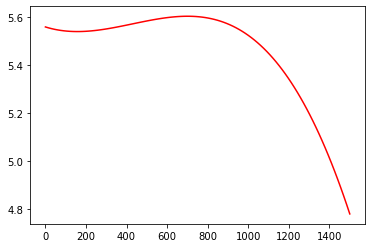

In [44]:
plt.plot(xp, p(xp), color='red')

<Figure size 432x288 with 0 Axes>

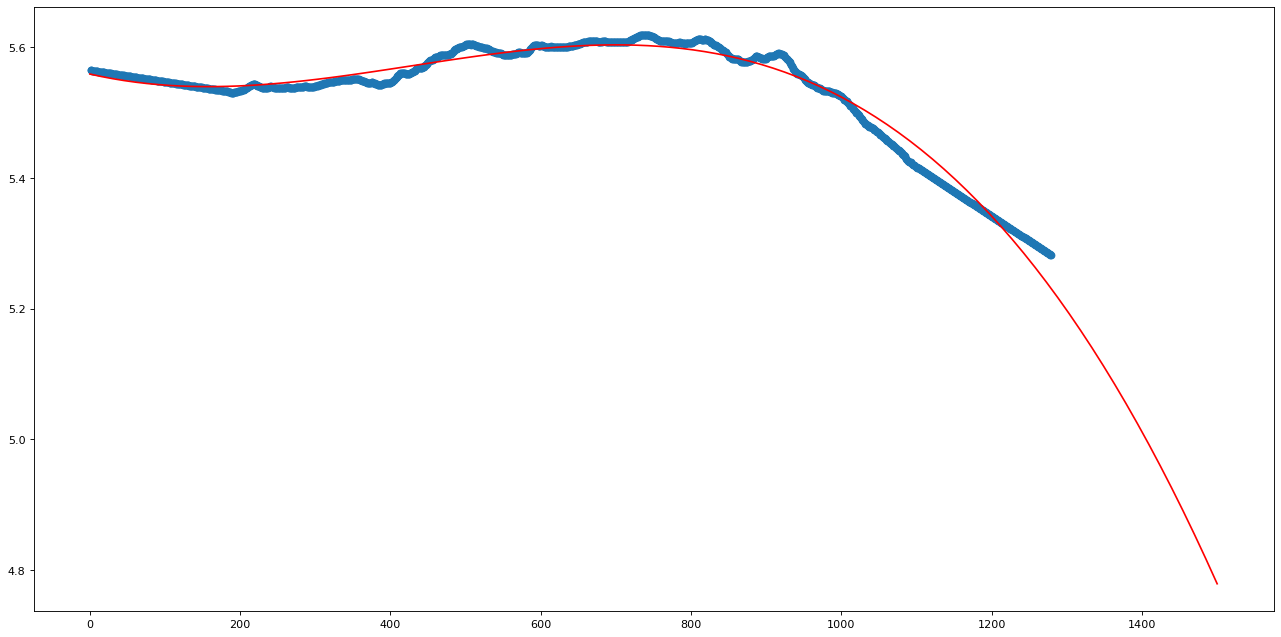

In [45]:
# plot the trend from the training set and overlap plot of the polyfit  
plt.figure()
plt.figure(figsize=(20, 10), dpi=80)
plt.scatter(X,y)
plt.plot(xp, p(xp), color='red')
plt.show()

# ARIMA model

In [46]:
from statsmodels.tsa.arima.model import ARIMA

In [47]:
def run_Arima(df,ts,p, d, q):
  model=ARIMA(df[ts], order=(p,d,q))
  results_arima=model.fit()#(disp=-1)

  len_results=len(results_arima.fittedvalues)
  ts_modified=df[ts][-len_results:]

  rss = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse=np.sqrt(rss/len(df[ts]))
  print('rmse:',rmse)
  plt.figure()
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color='red')

  plt.show()

  return results_arima

In [48]:
New_DF_training=New_DF_training.fillna(value=0)

## Run ARIMA on the residuals

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse: 0.06660726307793564


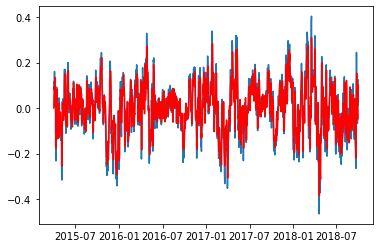

In [49]:
model_AR=run_Arima(df=New_DF_training,ts='residuals',p=23,d=0,q=0)

In [50]:
my_forecast = model_AR.forecast(274)

In [51]:
my_forecast

2018-10-01    0.078170
2018-10-02    0.053874
2018-10-03    0.033967
2018-10-04   -0.022424
2018-10-05   -0.011431
                ...   
2019-06-27    0.000062
2019-06-28    0.000062
2019-06-29    0.000062
2019-06-30    0.000062
2019-07-01    0.000062
Freq: D, Name: predicted_mean, Length: 274, dtype: float64

<Figure size 432x288 with 0 Axes>

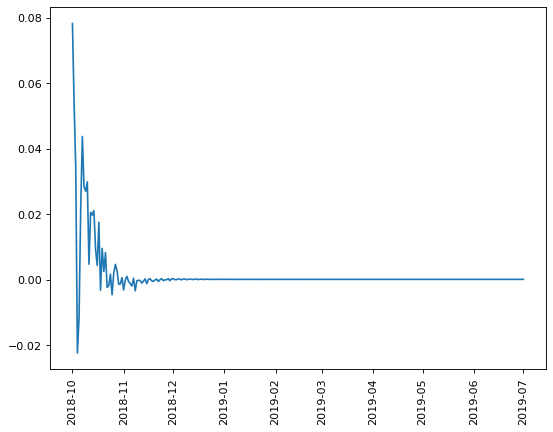

In [52]:
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)
plt.plot(my_forecast)

In [53]:
# saving the ARIMA model of the log of the full signal
model_AR.save('ARIMA_model_forecast_residuals(p=15, freq=365).pkl')

In [54]:
#load trained model 
from statsmodels.tsa.arima.model import ARIMAResults
model_AR = ARIMAResults.load('ARIMA_model_forecast_residuals(p=15, freq=365).pkl')

## Compare residuals prediction to residuals from validation set

In [55]:
#check validation set
df_validation

,ds,ts,ts_log
ds,,,
2018-10-01,2018-10-01,201.030,5.303454
2018-10-02,2018-10-02,226.232,5.421561
2018-10-03,2018-10-03,207.030,5.332864
2018-10-04,2018-10-04,180.827,5.197541
2018-10-05,2018-10-05,160.632,5.079116
...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195
2019-06-28,2019-06-28,170.858,5.140833
2019-06-29,2019-06-29,151.068,5.017730


In [56]:
decomposition = seasonal_decompose(df_validation['ts_log'], period=45, extrapolate_trend=4)

In [57]:
New_DF_validation=df_validation.copy()
New_DF_validation.loc[:,'trend']=decomposition.trend
New_DF_validation.loc[:,'seasonal']=decomposition.seasonal
New_DF_validation.loc[:,'residuals']=decomposition.resid

In [58]:
New_DF_validation

,ds,ts,ts_log,trend,seasonal,residuals
ds,,,,,,
2018-10-01,2018-10-01,201.030,5.303454,5.120666,0.008258,0.174530
2018-10-02,2018-10-02,226.232,5.421561,5.129439,0.015656,0.276467
2018-10-03,2018-10-03,207.030,5.332864,5.138211,0.001465,0.193187
2018-10-04,2018-10-04,180.827,5.197541,5.146983,0.021675,0.028882
2018-10-05,2018-10-05,160.632,5.079116,5.155755,0.025258,-0.101898
...,...,...,...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195,4.948230,0.014124,0.167841
2019-06-28,2019-06-28,170.858,5.140833,4.942289,0.008258,0.190286
2019-06-29,2019-06-29,151.068,5.017730,4.936348,0.015656,0.065726


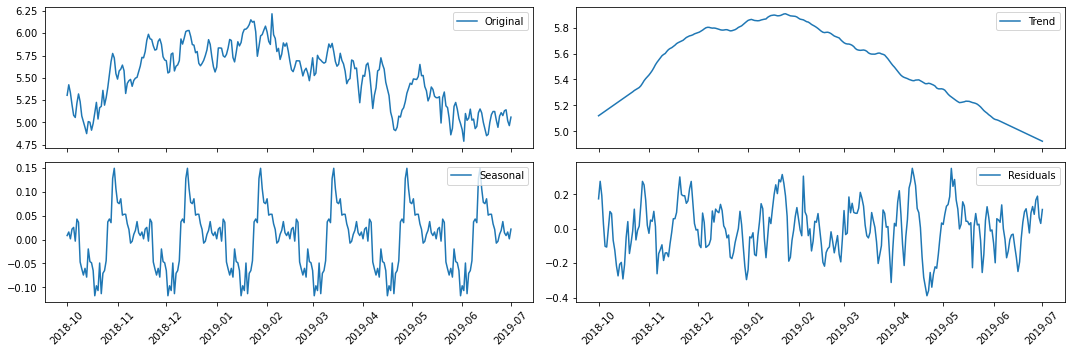

In [59]:
plot_decomposition(New_DF_validation,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

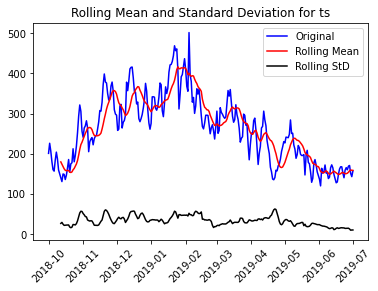

Results:
Test Statistic             -1.786610
p-value                     0.387129
# Lags Used                 9.000000
Number of Observations    264.000000
Critical value(1%)         -3.455365
Critical value(5%)         -2.872551
Critical value(10%)        -2.572638
dtype: float64


In [60]:
# test for stationarity on the full signal of the validation set
test_stationary(New_DF_validation,'ts')

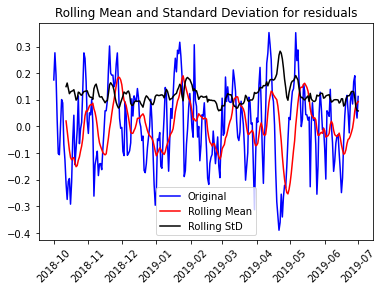

Results:
Test Statistic           -6.395581e+00
p-value                   2.054785e-08
# Lags Used               8.000000e+00
Number of Observations    2.650000e+02
Critical value(1%)       -3.455270e+00
Critical value(5%)       -2.872509e+00
Critical value(10%)      -2.572615e+00
dtype: float64


In [61]:
# test for stationarity on the noise of the validation set
test_stationary(New_DF_validation,'residuals')

In [62]:
start = len(New_DF_training)
end = len(New_DF_training)+len(New_DF_validation)-1
pred = model_AR.predict(start=start, end=end).rename('ARIMA Predictions')
pred_DF = pd.DataFrame(pred)
pred_DF['Date']=pred_DF.index

In [63]:
pred_DF #ARIMA forecasts of consumption

,ARIMA Predictions,Date
2018-10-01,0.078170,2018-10-01
2018-10-02,0.053874,2018-10-02
2018-10-03,0.033967,2018-10-03
2018-10-04,-0.022424,2018-10-04
2018-10-05,-0.011431,2018-10-05
...,...,...
2019-06-27,0.000062,2019-06-27
2019-06-28,0.000062,2019-06-28
2019-06-29,0.000062,2019-06-29
2019-06-30,0.000062,2019-06-30


In [64]:
from datetime import date, timedelta
 
sdate = '2018-10-01'
edate = '2019-07-01'
date_list = pd.date_range(sdate, edate, periods=274).tolist()

Text(0, 0.5, 'consumption')

<Figure size 432x288 with 0 Axes>

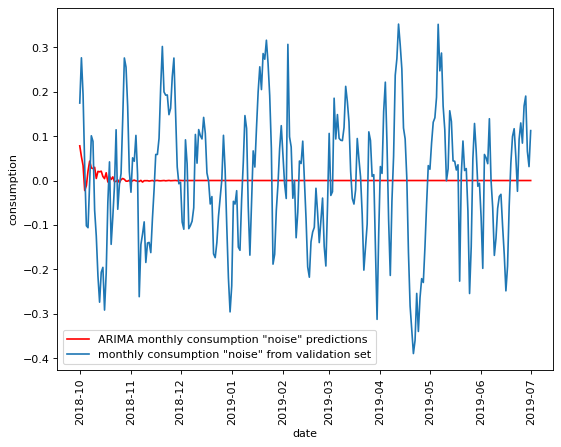

In [65]:
# plot ARIMA residuals forecast and validation set residuals
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plot_1, = plt.plot(date_list, pred_DF['ARIMA Predictions'], color='red', label ='ARIMA monthly consumption "noise" predictions')
plot_2, = plt.plot(date_list, New_DF_validation['residuals'], label ='monthly consumption "noise" from validation set')
plt.legend(handles=[plot_1, plot_2])
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("consumption")
#plt.ylim([-0.3, 0.3])

# Generating a forecast signal and comparing to the validation set

- sum residuals ARIMA forecast, with trend forecast from polyfit of training and seasonality extraction

In [67]:
# create the trend for the validation period from the polyfit coefficients generated from the training set
xp = np.linspace(0,273,274)
trend = p(xp)

# add the trend to the pred_DF dataframe
pred_DF['trend'] = trend.tolist()

# extract the seasonality from the training set i.e. the last 274 rows of the training set and add them as a column
# to pred_DF
training_seasonal = New_DF_training['seasonal'].iloc[-274:]
pred_DF['seasonal'] = training_seasonal.tolist()

In [68]:
# sum all the values from the trend, seasonal and ARIMA noise prediction
pred_DF['total_signal'] = pred_DF['ARIMA Predictions'] + pred_DF['trend'] + pred_DF['seasonal']

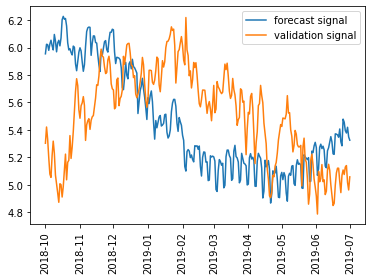

In [72]:
# plot the forecast signal along with the validation signal
plt.xticks(rotation=90)
plot_1, = plt.plot(pred_DF.Date, pred_DF.total_signal, label ='forecast signal')
plot_2, = plt.plot(New_DF_validation.ds, New_DF_validation.ts_log, label ='validation signal')
plt.legend(handles=[plot_1, plot_2])